In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ggplot import *
import re

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

C:\Users\v-avkama\AppData\Local\Continuum\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\v-avkama\AppData\Local\Continuum\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\v-avkama\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sms = pd.read_csv(r'C:\Users\v-avkama\Documents\MIsc\spam.csv',sep = ',',encoding='Latin-1',names =['class','sms','x2','x3','x4'],error_bad_lines  = False)

In [3]:
sms.head()

,class,sms,x2,x3,x4
0,v1,v2,NaN,NaN,NaN
1,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
2,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
4,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN


In [4]:
sms.drop(0,inplace=True)

In [5]:
sms.drop(['x2','x3','x4'],axis=1,inplace=True)

In [6]:
sms.head()

,class,sms
1,ham,"Go until jurong point, crazy.. Available only ..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
sms['length'] = sms['sms'].apply(lambda x: len(x))

In [8]:
sms.head()

,class,sms,length
1,ham,"Go until jurong point, crazy.. Available only ...",111
2,ham,Ok lar... Joking wif u oni...,29
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
4,ham,U dun say so early hor... U c already then say...,49
5,ham,"Nah I don't think he goes to usf, he lives aro...",61


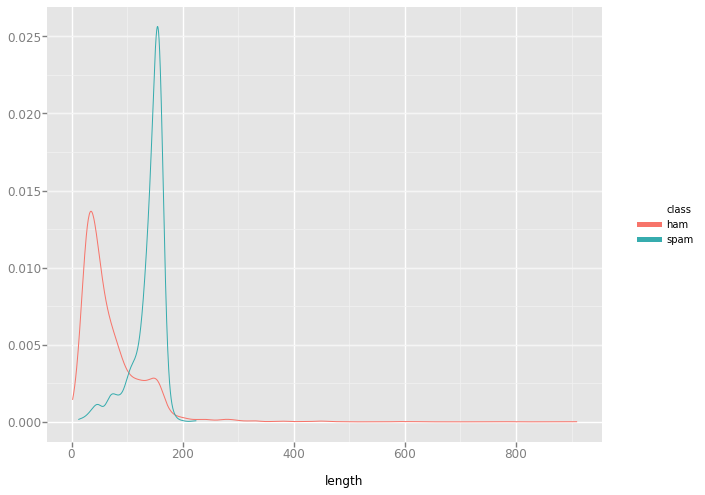

<ggplot: (189093986210)>

In [9]:
ggplot(aes('length',color = 'class'),sms)+geom_density() #+geom_histogram()

## Cleaning

In [10]:
stemmer = SnowballStemmer('english')
words = stopwords.words('english')

In [11]:
sms['cleansms'] = sms['sms'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]"," ",x).split()
                                                 if i.lower not in words]).lower())

In [12]:
sms.head()

,class,sms,length,cleansms
1,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazi avail onli in bugi...
2,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri in a wkli comp to win fa cup final ...
4,ham,U dun say so early hor... U c already then say...,49,u dun say so earli hor u c alreadi then say
5,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goe to usf he live around...


In [13]:
sms.drop('sms',axis = 1,inplace = True)

In [14]:
sms.head()

,class,length,cleansms
1,ham,111,go until jurong point crazi avail onli in bugi...
2,ham,29,ok lar joke wif u oni
3,spam,155,free entri in a wkli comp to win fa cup final ...
4,ham,49,u dun say so earli hor u c alreadi then say
5,ham,61,nah i don t think he goe to usf he live around...


In [15]:
pipeline = Pipeline([('vectorize', TfidfVectorizer(stop_words= 'english')),
                   ('selectkbest',SelectKBest(chi2,k = 2000)),
                    ('clf',LinearSVC(C=1.0,penalty='l1',max_iter=3000,dual=False))])
                   

In [16]:
np.random.seed(625)
X_train,X_test,Y_train,Y_test = train_test_split(sms['cleansms'],sms['class'],test_size = 0.3)

In [17]:
model = pipeline.fit(X_train,Y_train)

In [18]:
confusion_matrix(Y_test,pipeline.predict(X_test))

array([[1453,    8],
       [  22,  189]], dtype=int64)

In [19]:
conf_matrix = pd.crosstab(Y_test,pipeline.predict(X_test),rownames=['Actual'],colnames=['Predicted'])
conf_matrix

Predicted,ham,spam
Actual,,
ham,1453,8
spam,22,189


In [20]:
print("Your Model's accuracy is {}".format(
                            sum([conf_matrix[i][i] 
                                 for i in conf_matrix.index])/sum(sum([conf_matrix[i] for i in conf_matrix.index]))
))

print("Your Model's precision is {}".format(
                            conf_matrix['ham']['ham']
                                 /sum(conf_matrix['ham'])
))

print("Your Model's recall is {}".format(
                            conf_matrix['ham']['ham']
                                 /np.sum(conf_matrix[0:1].values)
))

Your Model's accuracy is 0.9820574162679426
Your Model's precision is 0.9850847457627119
Your Model's recall is 0.9945242984257358


In [21]:
pipeline_log = Pipeline([('vectorize', TfidfVectorizer(stop_words= 'english')),
                   ('selectkbest',SelectKBest(chi2,k = 2000)),
                    ('clf',LogisticRegression(C=1.0,penalty='l1',max_iter=3000,dual=False))])

In [22]:
log_model = pipeline_log.fit(X_train,Y_train)

In [23]:
confusion_matrix(Y_test,log_model.predict(X_test))

array([[1453,    8],
       [  54,  157]], dtype=int64)

In [24]:
def create_ROC(probs,testset,check_label):
    TPR = []
    FPR = []
    for i in range(0,100,10):
        threshold = i/100
        TP = FP = TN = FN =0
        for j in range(0,len(probs)):
            if testset.iloc[j] == check_label:
                if probs[j][0] >= threshold:
                    TP +=1
                else:
                    FN +=1
            else:
                if probs[j][0] < threshold:
                    TN +=1
                else:
                    FP +=1
        TPR.append(TP / (TP+FN+1))
        FPR.append(1 - (TN / (TN+FP+1)))
    df = {'tpr': TPR, 'fpr': FPR}
    df = pd.DataFrame(df)
    ax = df.plot(x = 'fpr' , y = 'tpr',xlim=(0,1),title = "ROC Curve",style= '-.',figsize= (10,8),legend=False,color = 'lightgray',kind = 'area')
    ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate")
    return ax

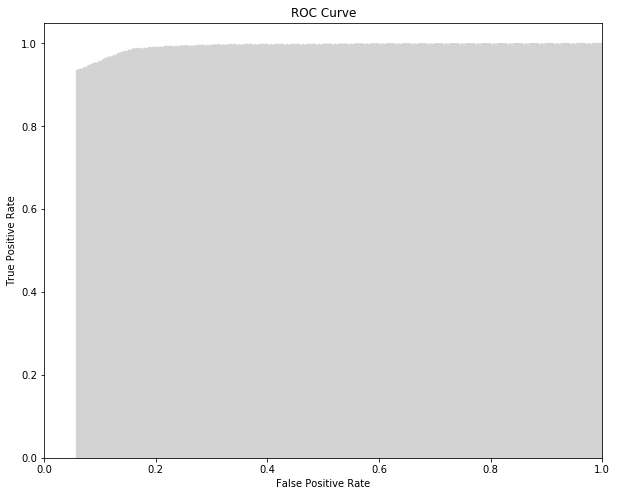

In [25]:
create_ROC(pipeline_log.predict_proba(X_test),Y_test,'ham')